# House Price Prediction


## Models

This consists the codes for predicting house prices with regression models and ensemble methods.

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
### Read in the data
df = pd.read_csv('../project-house-price-prediction/data/train.csv')
df_test = pd.read_csv('../project-house-price-prediction/data/test.csv')

## Data
The data preprocessing follows the data exploration done in the notebook notebook data-exploration-and-preprocessing and 

In [4]:
from sklearn.base import BaseEstimator, TransformerMixin

In [5]:
class CleanHouseAttributes(BaseEstimator, TransformerMixin):
    """Apply rules during data exploration to clean house price dataset"""
    
    def fit(self, x, y=None):
        return self
    
    def transform(self, df_house_price, cols_to_drop, target_col):
        # Age of building/remodle from YearBuilt and YearRemodAdd
        df_house_price['AgeBuilding'] = 2012 - df_house_price['YearBuilt']
        df_house_price['AgeRemodel'] = 2012 - df_house_price['YearRemodAdd']
    
        # Remove categories not exist in test.csv
        df_filtered = df_house_price[(df_house_price['HouseStyle'] != '2.5Fin') &
                                     (df_house_price['Exterior1st'] != 'Stone') &
                                     (df_house_price['Exterior1st'] != 'ImStucc') &
                                     (df_house_price['Exterior2nd'] != 'Other')]
        
        # Drop columns
        df_dropped = df_filtered.drop(cols_to_drop + target_col, axis=1)
            
        # Fill NA for numeric columns
        df_numeric = df_dropped.select_dtypes(include=['int64', 'float64']).apply(lambda x: x.fillna(x.mean()), axis=1)
        
        # Create dummies for non numeric columns
        df_nonNumeric = pd.get_dummies(df_dropped.select_dtypes(include=['object']).fillna('NA'))
        
        # Create boolean variables for Alley, PoolQC, and Fence
        df['HasAlley'] = list(1 if x is None else 0 for x in df['Alley'])
        df['HasPool'] = list(1 if x is None else 0 for x in df['PoolQC'])
        df['Fence'] = list(1 if x is None else 0 for x in df['Fence'])
        
        X = pd.concat([df_numeric, df_nonNumeric], axis=1)
        y = df_filtered[target_col]

        return X, y

In [6]:
drop_cols = ['Id', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'TotalBsmtSF', 
             'TotRmsAbvGrd', 'MoSold', 'YrSold', 'Street', 'Alley', 'Utilities', 
             'LandSlope', 'Condition2', 'Heating', 'Functional', 'FireplaceQu', 
             'PoolQC', 'Fence', 'MiscFeature'            ]
target_col = ['SalePrice']

In [7]:
X, y = CleanHouseAttributes().transform(df, drop_cols, target_col)
X.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,1stFlrSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60.0,65.0,8450.0,7.0,5.0,196.0,706.0,0.0,150.0,856.0,...,0,0,0,1,0,0,0,0,1,0
1,20.0,80.0,9600.0,6.0,8.0,0.0,978.0,0.0,284.0,1262.0,...,0,0,0,1,0,0,0,0,1,0
2,60.0,68.0,11250.0,7.0,5.0,162.0,486.0,0.0,434.0,920.0,...,0,0,0,1,0,0,0,0,1,0
3,70.0,60.0,9550.0,7.0,5.0,0.0,216.0,0.0,540.0,961.0,...,0,0,0,1,1,0,0,0,0,0
4,60.0,84.0,14260.0,8.0,5.0,350.0,655.0,0.0,490.0,1145.0,...,0,0,0,1,0,0,0,0,1,0


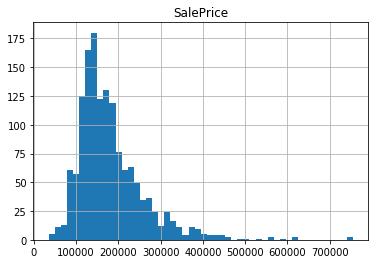

In [10]:
y.hist(bins=50)
plt.show()

<a id = "sklearn"></a>
## Regression

### Probblem Definition
**Input:** $x \in \mathbb{R}^{d}, d = 244$

**Output:** $y \in \mathbb{R}$

**Goal:** Find a function $f: \mathbb{R}^{d} \rightarrow \mathbb{R}$ such that $y \approx f(x;w)$ for the data pair $(x, y)$. $f(x;w)$ is call a $\textit{regression funciton}$. Its free parameters are $w$.

### 1. Linear Regression

A regression method is called $\textit{linear}$ if the prediction $f$ is a linear function of the unknown parameters $w$. 

The linear regression has the form
$$y_{i} \approx f(x_{i};w) = w_{0} + x_{i}^{T}w,$$

or in matrix form, 
$$y = \mathbf{X}w,$$
where a vector of 1 is attached in the first column of matrix $\mathbf{X}$.

With least square solution, we get the loss function for linear regression as
$$L = \sum_{i=1}^{n}\left(y_{i}-x_{i}^{T}w\right)^{2} = \|y -\mathbf{X}w\|^{2} = (y-\mathbf{X}w)^{T}(y-\mathbf{X}w)$$

If we take the gradient with respect to $w$, we find that
$$\nabla_{w}L = 2\mathbf{X}^T\mathbf{X}w-2\mathbf{X}^Ty = 0 \Rightarrow  w_{LS} = (\mathbf{X}^T \mathbf{X})^{−1}\mathbf{X}^T y$$

### Probablistic View of Linear Regression

Gaussian density in $n$ dimensions: Assume a diagonal covariance matrix $\Sigma = \sigma^2I$. The density is 
$$p(y|\mu, \sigma^2) = \frac{1}{(2\pi\sigma^2)^\frac{n}{2}} \exp (-\frac{1}{2\sigma^2}(y-\mu)^T(y-\mu)).$$
Plug $\mu=Xw$ into the multivariate Gaussian distribution and solve for $w$ using maximum likelihood.
$$w_{ML} = \operatorname*{arg\,max}_w \ln p(y|\mu = Xw, \sigma^2) 
= \operatorname*{arg\,max}_w -\frac{1}{2\sigma^2}\|y-Xw\|^2-\frac{n}{2}\ln(2\pi\sigma^2).$$

**Least squres (LS) and maximum likelihood (ML) share the same solution.**

$$\text{LS: } \operatorname*{arg\,min}_w\|y-Xw\|^2  \Leftrightarrow  \text{ML: } \operatorname*{arg\,max}_w-\frac{1}{2\sigma^2}\|y-Xw\|^2$$

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print("R-squared:", lr.score(X_test, y_test))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

R-squared: 0.857646419466
RMSE: 25676.4180144


#### Note: See appendix for interpreting the coefficient of linear regression
If the purpose of builing linear regression models is for interpretation. The package `statsmodels.api` would be a better option then the package `sklearn` for providing coefficients with p-value.

In [26]:
import statsmodels.api as sm

In [27]:
X_sm = sm.add_constant(X)
lr_sm = sm.OLS(y, X_sm)
lr_sm = lr_sm.fit()
print(lr_sm.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.854
Method:                 Least Squares   F-statistic:                     87.07
Date:                Wed, 04 Sep 2019   Prob (F-statistic):               0.00
Time:                        20:37:47   Log-Likelihood:                -16944.
No. Observations:                1448   AIC:                         3.409e+04
Df Residuals:                    1349   BIC:                         3.461e+04
Df Model:                          98                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -3640.1388 

### 2. Ridge Regression
Least square solution is unbiased but potentially has high variance. The value in $w_{ML}$ may be huge. In general, we often want to constraint the model parameters. One way is to add regularization. Ridge Regression addresses variance issues with $w_{ML}$ by using the squared penalty on the gression coefficient vector $w$,
$$w_{RR} = \operatorname*{arg\,min}_w \|y-\mathbf{X}w\|^2+\lambda\|w\|^2 = (\lambda\mathbf{I}+\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^Ty.$$

### Probablisitc View: Ridge Regression and Bayesian Modeling
Adding a $l2$ regularization term to linear regression is like defining a prior on the unknown parameter $w$ and trying to learn its posterior. 

In Bayesian setting, we can model the data as:

**Likelihood:** $y \sim N(Xw, \sigma^2I)$

**Prior:** $w \sim N(0, \lambda^{-1}I)$ Then 
$$p(w) = (\frac{\lambda}{2\pi})^{\frac{d}{2}} e^{-\frac{\lambda}{2}w^Tw}$$

Maximum $\textit{a poseriori}$ (MAP) estimation seeks the most probable value $w$ under the posterior:
$$w_{MAP} = \operatorname*{arg\,max}_w\ln p(w|y,X) = \operatorname*{arg\,max}_w\ln p(y|w,X) + \ln p(w)$$
$$=\operatorname*{arg\,max}_w\frac{1}{2\sigma^2}(y-Xw)^T(y-Xw) - \frac{\lambda}{2}w^Tw + const.$$

Take gradient of the function, we can get the solution for $w_{MAP}$ = $(\lambda\sigma^2I+X^TX)^{-1}X^Ty$.

**Notice that $w_{MAP} = w_{RR}$**

In [28]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

In [31]:
param_grid = {'alpha': np.linspace(0, 10, 101)}
ridge = Ridge(normalize=True)
gs_ridge = GridSearchCV(ridge, param_grid, cv=5)
gs_ridge.fit(X_train, y_train)
print(gs_ridge.best_params_, gs_ridge.best_score_)

y_pred = gs_ridge.predict(X_test)
print("R-squared:", gs_ridge.score(X_test, y_test))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

{'alpha': 0.70000000000000007} 0.798337499746
R-squared: 0.892846699556
RMSE: 22276.810783


### 3. Sparse Regression (Lasso)
The pentalty term of Lasso will select a small subset of the d dimensions and switch off the rest, encourasing sparse solutions.

**LASSO:** Least Absolute Shrinkage and Selection Operator

With the LASSO, we replac the $l_2$ penalty with an $l_1$ penalty:
$$w_{lasso} = \operatorname*{arg\,min}_w \|y-\mathbf{X}w\|^2+\lambda\|w\|_1,$$
where
$$\|w\|_1 = \sum_{j=1}^{d}|w_j|.$$

In [40]:
# Suppress warnings from using Lasso
import warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [41]:
from sklearn.linear_model import Lasso

In [43]:
param_grid = {'alpha': np.linspace(0, 10, 11)}
lasso = Lasso(normalize=True)
gs_lasso = GridSearchCV(lasso, param_grid, cv=5)
gs_lasso.fit(X_train, y_train)
print(gs_lasso.best_params_, gs_lasso.best_score_)

y_pred = gs_lasso.predict(X_test)
print("R-squared:", gs_lasso.score(X_test, y_test))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

{'alpha': 10.0} 0.778958046344
R-squared: 0.883019421248
RMSE: 23275.9343009


### 4. Elastic Net
Elastic Net combines $l_1$ and $l_2$ penalties.
$$w_{elastic} = \operatorname*{argmin}_w \|y-\mathbf{X}w\|^2+\lambda_2\|w\|^2+\lambda_1\|w\|_1$$

In [21]:
from sklearn.linear_model import ElasticNet

In [54]:
param_grid = {'alpha': np.linspace(0, 1, 5), 'l1_ratio': [0.1, 1]}
en = ElasticNet()
gs_en = GridSearchCV(en, param_grid, cv=5)
gs_en.fit(X_train, y_train)
print(gs_en.best_params_, gs_en.best_score_)

y_pred = gs_en.predict(X_test)
print("R-squared:", gs_en.score(X_test, y_test))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

{'l1_ratio': 1, 'alpha': 1.0} 0.752483263323
R-squared: 0.859179034362
RMSE: 25537.8245446


### Model Comparison - Linear Regression, Ridge, Lasso, and Elastic Net
#### Predictive Performance
In general, regression models with regularization terms have better prediction, or generalization, than linear regression.

In [62]:
df_variance = pd.DataFrame({})
# Apply best models from grid search
for (k,v) in zip(['Linear Regression', 'Ridge Regression', 'Sparse Regression', 'Elastic Net'],
                 [lr, Ridge(alpha=0.7), Lasso(alpha=10), ElasticNet(alpha=1, l1_ratio=1)]):
    cv_results = cross_val_score(v, X, y, cv=5)
    df_variance[k] = cv_results

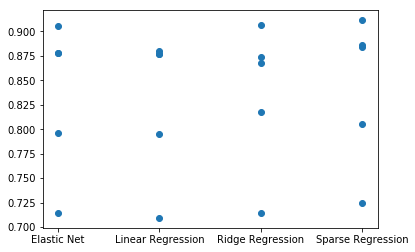

In [63]:
df_variance_plot = df_variance.melt()
plt.plot(df_variance_plot['variable'], df_variance_plot['value'], 'o')
plt.show()

#### Coefficients - Quadratic Penalty (Ridge) vs Linear Penalty (Lasso)
- Suppose $w_k$ is large, all other$w_j$ are very small but non-zero
- Linear penalty: Penalty should keep $w_k$ and push other $w_j$ to zero
- Quadratic penalty: Will favor entries $w_j$ with all have similar size, and so it will push $w_k$ towards small value.

Overall, a quadratic penalty favors many small but non-zero values, and a linear penalty term achieves sparsity

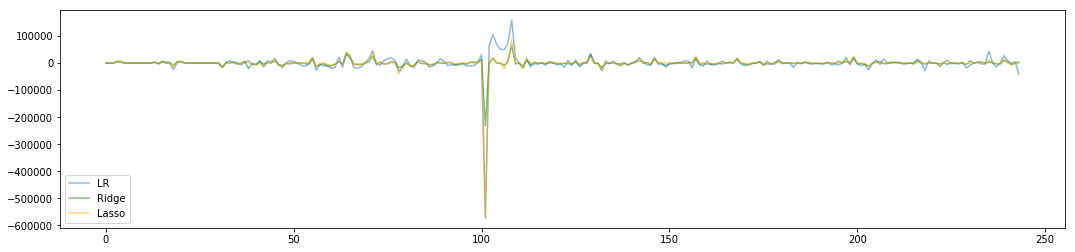

In [81]:
plt.figure(figsize=(18, 4))
plt.plot(lr.coef_.squeeze(), label='LR', alpha = 0.5)
plt.plot(gs_ridge.best_estimator_.coef_.squeeze(), color = 'green', label='Ridge', alpha =0.5)
plt.plot(gs_lasso.best_estimator_.coef_, color = 'orange', label='Lasso', alpha =0.5)
plt.legend();

### 5. Kernel Ridge
Definition from sklearn: Kernel ridge regression (KRR) combines ridge regression (linear least squares with l2-norm regularization) with the kernel trick. It thus learns a linear function in the space induced by the respective kernel and the data.

### Kernels
A kernel $K(\cdot,\cdot): \mathbb{R}^d \times \mathbb{R}^d \rightarrow$ is a symmetric function defined as follows:

For any set of n data points $x_1,...,x_n \in \mathbb{R}^d$, the $n \times n$ matrix $K$, where $K_{ij} = K(x_i, x_j)$, is positive semidefinite.

From Mercer's theorem, if the function $K(\cdot,\cdot)$ satisfies the above properties, then there exists a mapping $\pi: \mathbb{R}^d \rightarrow \mathbb{R}^D$ such that
$$K(x_i, x_j) = \pi(x_i)^T\pi(x_j).$$

We usually only define $K(\cdot,\cdot)$ and avoid ever using $\phi(\cdot)$. However, the kernel $K(\cdot,\cdot)$ implies that x_i and x_j have been mapped into a higher, or infinite, dimension $D$ to get the output.

In [72]:
from sklearn.kernel_ridge import KernelRidge

In [80]:
param_grid = {'alpha': [0.1, 1, 10, 100]}
kr = KernelRidge()
gs_kr = GridSearchCV(kr, param_grid, cv=5)
gs_kr.fit(X_train, y_train)
print(gs_kr.best_params_, gs_kr.best_score_)

y_pred = gs_kr.predict(X_test)
print("R-squared:", gs_kr.score(X_test, y_test))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

{'alpha': 10} 0.75619309626
R-squared: 0.876486633334
RMSE: 23917.0284244


### 6. Regression Tree

In [82]:
from sklearn.tree import DecisionTreeRegressor

In [86]:
param_grid = {'max_depth': np.arange(4,9), 
              'min_samples_split': np.arange(2,11), 
              'max_features': ['auto', 'sqrt']}
dt = DecisionTreeRegressor()
gs_dt = GridSearchCV(dt, param_grid, cv=5)
gs_dt.fit(X_train, y_train)
print(gs_dt.best_params_, gs_dt.best_score_)

y_pred = gs_dt.predict(X_test)
print(gs_dt.score(X_test, y_test))
print(np.sqrt(mean_squared_error(y_test, y_pred)))

{'max_depth': 7, 'max_features': 'auto', 'min_samples_split': 9} 0.697995302602
0.766038280672
32917.181488


## Ensemble Models

### Bagging

Bagging uses the boostrap for regression or classification: **Bagging** = **B**oostrap **agg**regation

#### Algorithm
For $b = 1,...,B$:
1. Draw a boostrap sample $\mathbb{B}_b$ of size $n$ from training data. (Boostrap = resampling with replacement)
2. Train a classifier or regression model $f_b$ on $\mathbb{B}_b$
    - For a new point $x_0$, compute:
    $$f_avg(X_0) = \frac{1}{B}\sum{b=1}^{B}f_b(X_0)$$
    - For regression, f_avg(x_0) is the prediction
    - For classification, view f_avg(x_0) as an average over $B$ votes. Pick the majority.

In [87]:
from sklearn.ensemble import BaggingRegressor

In [109]:
def apply_bagging(model, X_train, y_train, X_test, y_test, iteration = 10):
    bagging = BaggingRegressor(model,
                               n_estimators=iteration)
    bagging.fit(X_train, y_train)
    y_pred = bagging.predict(X_test)
    print('R-squared: {} RMSE: {}'.format(bagging.score(X_test, y_test), 
                                          np.sqrt(mean_squared_error(y_test, y_pred))))

In [112]:
# initiate best models from previous codes
lr = LinearRegression()
ridge = Ridge(alpha=0.7, normalize=True)
lasso = Lasso(alpha=10, normalize=True)
kr = KernelRidge(alpha=10)
dt = DecisionTreeRegressor(max_depth=7, max_features='auto', min_samples_split=9)

models = [lr, ridge, lasso, kr, dt]
model_names = ['Linear Regression',
               'Ridge Regression',
               'Sparse Regression',
               'Kernel Regression',
               'Decision Tree Regression']
for (k, v) in zip(model_names, models):
    print(k)
    apply_bagging(v, X_train, np.ravel(y_train), X_test, y_test, 100)

Linear Regression
R-squared: -65639786.51282491 RMSE: 551358181.1400583
Ridge Regression
R-squared: 0.8960664798194211 RMSE: 21939.567313765543
Sparse Regression
R-squared: 0.8884988886813485 RMSE: 22724.26461515499
Kernel Regression
R-squared: 0.8908491365634631 RMSE: 22483.49528643615
Decision Tree Regression
R-squared: 0.859535004883625 RMSE: 25505.526566497887


#### Model Improvement
- We can further use the parameter max_features in BaggingRegressor to select a subset of features. However, if we use all features by default setting, bagged regressions are correlated. In general, when bootstrap samples are correlated, the benefit of bagging decreases. This could be the reason why bagging doesn't improve much compare to single models.
- Random forests model is a modification of bagging where trees are designed to reduce correlation. The modification is to only consider random subset of dimensions of $x \in \mathbb{R}^d$.

### Random Forest

#### Algorithm
Input parameter: $m$ - a positive integer with $m<d$ often $m \approx \sqrt{d}$
For $b = 1,...,B$:
1. Draw a boostrap sample $\mathbb{B}_b$ of size $n$ from the training data.
2. Train a tree classfier on $\mathbb{B}_b$, where each split is computed as follows:
    - Randomly select $m$ dimensions of $x \in \mathbb{R}^d$ newly chosen for each $b$.
    - Make the best split restricted to that subset of dimensions.

In [114]:
from sklearn.ensemble import RandomForestRegressor

In [115]:
param_grid = {'n_estimators':[100, 500, 1000],
              'max_depth': np.arange(4, 10), 
              'max_features': ['auto', 'sqrt']}
rf = RandomForestRegressor()
gs_rf = GridSearchCV(rf, param_grid, cv=5)
gs_rf.fit(X_train, np.ravel(y_train))
print(gs_rf.best_params_, gs_rf.best_score_)

y_pred = gs_rf.predict(X_test)
print(gs_rf.score(X_test, y_test), np.sqrt(mean_squared_error(y_test, y_pred)))

{'max_depth': 9, 'max_features': 'auto', 'n_estimators': 500} 0.837605990642
0.869178488593 24614.432142


### AdaBoosting

In bagging, each training example is equally likely to be picked. In boosting, the probability of a particular example being in the training set of a particular machine depends on the performance of the prior machines on that sample. In each round, each training samples is assigned a new weight depending on the prediction performance from the previous round. More weights are assigned to samples with worse prediction so that each subsequent machine would focus on training the "difficult" samples.

#### Algorithm
Given $(x_1, y_1),...,(x_n, y_n)$, assign a weight $w_i=1$ for $i = 1,...,n$.

For $t = 1,..., T$
1. The probability that training sample $i$ is in the training set is $p_i = \frac{w_i}{\sum w_i}$ where the summation is over all members of the training set. Pick $n$ samples with replacement to form the training set.
2. Construct a regression machine $t$.
3. Make prediction $y_i^{(p)}(x_i)$ for $i=1,...,n$ with machine $t$. **Note: $y_i^{(p)}(x_i)$ is not the final prediction.**
4. Calculate a loss for $y_i^{(p)}(x_i)$ and $y_i$. The loss function may be of any functional form as long as $L \in$ [0,1]. If we let $$ D = sup|y_i^{(p)}(x_i)-y_i|  i = 1,...,n,$$ which means D is the largest error, then we have three candidate loss functions:
$$L_i=\frac{|y_i^{(p)}(x_i)-y_i|}{D} \textit{(linear)}$$
$$L_i=\frac{|y_i^{(p)}(x_i)-y_i|^2}{D^2} \textit{(square law)}$$
$$L_i=1-\exp\left[\frac{-|y_i^{(p)}(x_i)-y_i|}{D}\right] \textit{(exponential)}$$
5. Calculate aveage loss $\overline{L}=\sum_{i=1}^{N_1}L_ip_i$
6. Form $\beta=\frac{\overline{L}}{1-\overline{L}}$. $\beta$ is a measure of confidence in the predictor. Low $\beta$ means high confidence in the prediction.
7. Update the weights: $w_i \rightarrow w_i\beta^{[1-L_i]}$. The smaller the loss, the more weight is reduced , making the sample less likely to be picked in the next round.
8. For a particular input $x_i$, each of the $T$ machines makes a prediction $h_t, t=1,...,T$. $h_f$ is cumulative prediction using the $T$ predictors:
$$h_f = inf\bigg\{y \in Y: \sum_{t:h_t\leq y}log(\frac{1}{\beta_t})\geq\frac{1}{2}\sum_{t}log(\frac{1}{\beta_t})\bigg\}$$
This equation is essentially relabel $y_i$ such that $y_i^{(1)}<y_i^{(2)}<,...,y_i^{(T)}$. Then sum the $log(1/\beta_t)$ until we reach the smallest t that is equal or grater than $\frac{1}{2}\sum_{t}log(\frac{1}{\beta_t})$. This is the weighted median. If the $\beta_t$ were all equal, this would be the median.


In [322]:
from sklearn.ensemble import AdaBoostRegressor

In [334]:
abr = AdaBoostRegressor(DecisionTreeRegressor(max_depth=20), 
                        n_estimators=100,
                        loss='exponential')
abr.fit(X_train, np.ravel(y_train))
y_pred = abr.predict(X_test)
print(abr.score(X_test, y_test), np.sqrt(mean_squared_error(y_test, y_pred)))

0.876690211953 23897.3098963


In [411]:
param_grid = {'n_estimators': [100, 250, 500]}
abr = AdaBoostRegressor(DecisionTreeRegressor(max_depth=10))
gs_cv = GridSearchCV(abr, param_grid, cv = 5)
gs_cv.fit(X_train, np.ravel(y_train))
print(gs_cv.best_params_, gs_cv.best_score_)

{'n_estimators': 500} 0.851484206112


### Gradient Boost

In [341]:
from sklearn.ensemble import GradientBoostingRegressor

In [345]:
gbr = GradientBoostingRegressor(learning_rate = 0.01,
                                n_estimators = 1000,
                                max_depth = 10)
gbr.fit(X_train, np.ravel(y_train))
y_pred = gbr.predict(X_test)
print(gbr.score(X_test, y_test), np.sqrt(mean_squared_error(y_test, y_pred)))

0.828102282846 28215.3404201


In [359]:
param_grid = {'n_estimators': [100, 150],
              'learning_rate': np.linspace(0.1, 0.2, 10)}
gbr = GradientBoostingRegressor(max_depth=8, max_features='sqrt')
gs_cv = GridSearchCV(estimator=gbr, param_grid=param_grid, cv=5)
gs_cv.fit(X_train, np.ravel(y_train))
print(gs_cv.best_params_, gs_cv.best_score_)

{'n_estimators': 100, 'learning_rate': 0.15555555555555556} 0.870965627566


<a id = "conclusion"></a>
## Performance & Conclusion

In [99]:
X_test_kaggle, y_test_kaggle = house_price_data_cleaning(df_test, drop_cols)
lr_kaggle = LinearRegression()
lr_kaggle.fit(X, y)
y_pred_kaggle = lr_kaggle.predict(X_test_kaggle)
y_pred_kaggle

array([[ 116384.01574647],
       [ 158760.01461952],
       [ 175540.3231846 ],
       ..., 
       [ 181877.81006835],
       [  93139.64124942],
       [ 220235.59814217]])

### References for Model Introduction and Algorithms
- Applied Machine Learning Certification - Columnbia Engineering Executive Education

#### Note: The coding was done through personal works and researches and not borrowed from the certification course.

In [177]:
# Kaggle score 0.21015; Rank 3817
pd.DataFrame({'Id': df_test.Id.values,
              'SalePrice': np.squeeze(y_pred_kaggle)}).to_csv('../project-house-price-prediction/data/pred.csv',
                                                             index=False)

In [35]:
# Kaggle score 0.19031; Rank 3619
ridge_kaggle = Ridge(alpha=0.5, normalize=True)
ridge_kaggle.fit(X, y)
y_pred_kaggle = ridge_kaggle.predict(X_test_kaggle)
pd.DataFrame({'Id': df_test.Id.values,
              'SalePrice': np.squeeze(y_pred_kaggle)}).to_csv('../project-house-price-prediction/data/pred.csv',
                                                              index=False)

In [100]:
# Worse performance than Ridge Regression
elastic_net_kaggle = ElasticNet(alpha=0.01, l1_ratio=0.1)
elastic_net_kaggle.fit(X, y)
y_pred_kaggle = elastic_net_kaggle.predict(X_test_kaggle)
pd.DataFrame({'Id': df_test.Id.values,
              'SalePrice': np.squeeze(y_pred_kaggle)}).to_csv('../project-house-price-prediction/data/pred.csv',
                                                              index=False)

c:\users\byron\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [124]:
# 0.18998; Rank 3587
alpha_space = np.linspace(0, 1, 101)
param_grid = {'alpha': alpha_space}
ridge = Ridge(normalize=True)
gm_cv = GridSearchCV(ridge, param_grid, cv=6)
gm_cv.fit(X, y)
y_pred_kaggle = gm_cv.predict(X_test_kaggle)
pd.DataFrame({'Id': df_test.Id.values,
              'SalePrice': np.squeeze(y_pred_kaggle)}).to_csv('../project-house-price-prediction/data/pred.csv',
                                                              index=False)

In [264]:
alpha_space = np.linspace(1, 5, 101)
param_grid = {'alpha': alpha_space}
kr = KernelRidge()
gs_cv = GridSearchCV(kr, param_grid, cv=5)
gs_cv.fit(X, y)
y_pred_kaggle = gs_cv.predict(X_test_kaggle)
pd.DataFrame({'Id': df_test.Id.values,
              'SalePrice': np.squeeze(y_pred_kaggle)}).to_csv('../project-house-price-prediction/data/pred.csv',
                                                              index=False)

In [379]:
# 0.14760; rank 2759
param_grid = {'n_estimators': [50, 80, 100],
              'learning_rate': np.linspace(0.1, 0.2, 10)}
gbr = GradientBoostingRegressor(max_depth=8)
gs_cv = GridSearchCV(estimator=gbr, param_grid=param_grid, cv=5)
gs_cv.fit(X, np.ravel(y))
y_pred_kaggle = gs_cv.predict(X_test_kaggle)
pd.DataFrame({'Id': df_test.Id.values,
              'SalePrice': np.squeeze(y_pred_kaggle)}).to_csv('../project-house-price-prediction/data/pred.csv',
                                                              index=False)

KeyboardInterrupt: 

In [391]:
# 0.14385; Rank 2637
param_grid = {'learning_rate': np.linspace(0.1, 0.125, 11),
              'n_estimators': [100, 120]            
              }
gbr = GradientBoostingRegressor(max_depth=8, max_features='sqrt', subsample = 0.6)
gs_cv = GridSearchCV(estimator=gbr, param_grid=param_grid, cv=5)
gs_cv.fit(X, np.ravel(y))
print(gs_cv.best_params_, gs_cv.best_score_)
y_pred_kaggle = gs_cv.predict(X_test_kaggle)
pd.DataFrame({'Id': df_test.Id.values,
              'SalePrice': np.squeeze(y_pred_kaggle)}).to_csv('../project-house-price-prediction/data/pred.csv',
                                                              index=False)

{'n_estimators': 100, 'learning_rate': 0.12} 0.883070305873


In [419]:
# 0.14334; Rank 2621
param_grid = {'learning_rate': [0.12],
              'n_estimators': [100, 500, 1000]
              }
gbr = GradientBoostingRegressor(subsample=0.6, max_depth=8, max_features='sqrt')
gs_cv = GridSearchCV(estimator=gbr, param_grid=param_grid, cv=5)
gs_cv.fit(X, np.ravel(y))
print(gs_cv.best_params_, gs_cv.best_score_)
y_pred_kaggle = gs_cv.predict(X_test_kaggle)
pd.DataFrame({'Id': df_test.Id.values,
              'SalePrice': np.squeeze(y_pred_kaggle)}).to_csv('../project-house-price-prediction/data/pred.csv',
                                                              index=False)

{'n_estimators': 500, 'learning_rate': 0.12} 0.880555757765


In [446]:
param_grid = {'learning_rate': [0.12],
              'n_estimators': [100, 500]
              }
gbr = GradientBoostingRegressor(subsample=0.6, max_depth=8, max_features='sqrt')
gs_cv = GridSearchCV(estimator=gbr, param_grid=param_grid, cv=5)
gs_cv.fit(X_train, np.ravel(y_train))
print(gs_cv.best_params_, gs_cv.best_score_)
y_pred = gs_cv.predict(X_test)
print(gs_cv.score(X_test, y_test))
print(np.sqrt(mean_squared_error(y_pred, y_test))/np.mean(y_test))

{'n_estimators': 500, 'learning_rate': 0.12} 0.858656448642
0.879818737007
SalePrice    0.139093
dtype: float64


In [437]:
y[:5]

,SalePrice
0,208500
1,181500
2,223500
3,140000
4,250000


In [ ]:
np.mean(y_pred - np.array(y))

In [417]:
# Try to get best training result
param_grid = {'learning_rate': np.linspace(0.115, 0.125, 6),
              'n_estimators': [1000, 1500],
              'max_depth': [7, 8]
              }
gbr = GradientBoostingRegressor(subsample=0.6, max_features='sqrt')
gs_cv = GridSearchCV(estimator=gbr, param_grid=param_grid, cv=5)
gs_cv.fit(X, np.ravel(y))
print(gs_cv.best_params_, gs_cv.best_score_)
y_pred_kaggle = gs_cv.predict(X_test_kaggle)
pd.DataFrame({'Id': df_test.Id.values,
              'SalePrice': np.squeeze(y_pred_kaggle)}).to_csv('../project-house-price-prediction/data/pred.csv',
                                                              index=False)

{'max_depth': 8, 'n_estimators': 1500, 'learning_rate': 0.121} 0.881553951019


In [375]:
param_grid = {'n_estimators': [250, 500, 750],
              'max_depth': [10]}
rf = RandomForestRegressor(min_samples_split = 5, min_samples_leaf = 3)
gs_cv = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)
gs_cv.fit(X, np.ravel(y))
#print(gs_cv.score(X_test, y_test))
y_pred_kaggle = gs_cv.predict(X_test_kaggle)
pd.DataFrame({'Id': df_test.Id.values,
              'SalePrice': np.squeeze(y_pred_kaggle)}).to_csv('../project-house-price-prediction/data/pred.csv',
                                                              index=False)

In [376]:
print(gs_cv.best_params_, gs_cv.best_score_)

{'max_depth': 10, 'n_estimators': 750} 0.851810295887


In [377]:
param_grid = {'n_estimators': [100, 250, 500]}
abr = AdaBoostRegressor(DecisionTreeRegressor(min_samples_split = 5, 
                                              min_samples_leaf = 3,
                                              max_depth=20))
gs_cv = GridSearchCV(abr, param_grid, cv = 5)
gs_cv.fit(X, np.ravel(y))
print(gs_cv.best_params_, gs_cv.best_score_)

{'n_estimators': 500} 0.871623084652


In [378]:
y_pred_kaggle = gs_cv.predict(X_test_kaggle)
pd.DataFrame({'Id': df_test.Id.values,
              'SalePrice': np.squeeze(y_pred_kaggle)}).to_csv('../project-house-price-prediction/data/pred.csv',
                                                              index=False)